In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from typing import Dict, Tuple
from IPython.display import display
from matplotlib import pyplot as plt

# Package dependencies:
# https://github.com/anabugaenko/liquidity
# https://github.com/anabugaenko/market_impact

from liquidity.features import compute_aggregate_features

from market_impact.fit import fit_scaling_law
from market_impact.util.utils import normalize_imbalances
from market_impact.response_functions import aggregate_impact
from market_impact.fss import find_shape_parameters, find_scale_factors, transform
from market_impact.util.plot_utils import plot_scaling_function, plot_collapsed_scaling_function

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

# Nonlinear aggregate price impact analysis 

See:

Lillo, F., Farmer, J.D. and Mantegna, R.N., 2003. Master curve for </br>
price-impact function. Nature, 421(6919), pp.129-130.

Patzelt, F. and Bouchaud, J.P., 2018. Universal scaling and nonlinearity of </br>
aggregate price impact in financial markets. Physical Review E, 97(1), p.012304.</br>

## Finitie-size scaling analysis
Finite-size scaling analysis a powerful tool that enables extraction of exponent of critical phenomena. Given data describing some dimensionless quantity, we estimate universal information from observables at finite-size system. The derivation of such scaling laws is supported by the renormalization-group argument. This notebook introduces a FSS based on the method of Leas-squares.

In [3]:
# Constants 
# DATA_RANGE = list(range(10, 151))
BINNING_FREQUENCIES = [10, 20, 50, 100, 150]

In [4]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'AAPL', 'GOOG']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'limit_orders')

stock_data = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2017-NEW.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_data[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_data['TSLA']
amzn_raw_df = stock_data['AMZN']
nflx_raw_df = stock_data['NFLX']
msft_raw_df = stock_data['MSFT']
ebay_raw_df = stock_data['EBAY']
aapl_raw_df = stock_data['AAPL']
goog_raw_df = stock_data['GOOG']

In [5]:
aapl_raw_df.head()

,Unnamed: 0,event_timestamp,side,size,old_size,price,old_price,price_level,old_price_level,price_changing,...,sign,price_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,337173,2017-01-03 10:30:00.241185845,BID,100,0,115.69,NaN,1,1,False,...,-1,0.000,-0.000,0.01,2017-01-03,-0.000245,14592056,118291,0.131202,-100
1,337174,2017-01-03 10:30:00.241372695,BID,100,0,115.69,NaN,1,1,False,...,-1,0.005,-0.005,0.01,2017-01-03,-0.000245,14592056,118291,0.131202,-100
2,337179,2017-01-03 10:30:00.544202801,BID,100,0,115.69,NaN,1,1,False,...,-1,0.000,-0.000,0.02,2017-01-03,-0.000245,14592056,118291,0.131202,-100
3,337180,2017-01-03 10:30:00.544207002,BID,100,0,115.69,NaN,1,1,False,...,-1,0.000,-0.000,0.02,2017-01-03,-0.000245,14592056,118291,0.131202,-100
4,337181,2017-01-03 10:30:00.544211904,BID,100,0,115.69,NaN,1,1,False,...,-1,0.000,-0.000,0.02,2017-01-03,-0.000245,14592056,118291,0.131202,-100


### Aggregate features 
We first coarse-grain the data into different binning frequencies $T$ that represent different system sizes (in event time) by marginalize over microscopic degrees of freedom in the system to yield an effective coarse-grained description at long distances.

In [6]:
# Compute aggregate features 
aggregate_features = compute_aggregate_features(aapl_raw_df, BINNING_FREQUENCIES)
display(aggregate_features)

,event_timestamp,midprice,summed_returns,sign,signed_volume,price_changing,daily_R1,daily_num,daily_vol,volume_imbalance,sign_imbalance,price_change_imbalance,average_num_at_best,average_vol_at_best,midprice_from_returns,T
1,2017-01-03 10:30:00.544292747,115.700,0.000,-1,-100,False,-0.000245,118291,14592056,-400,0,0,6.032068,762.184840,115.700,10
2,2017-01-03 10:30:00.602715704,115.700,-0.005,1,100,True,-0.000245,118291,14592056,-53,2,1,7.283424,1045.040418,115.700,10
3,2017-01-03 10:30:02.187943972,115.695,-0.005,1,100,False,-0.000245,118291,14592056,400,4,0,7.283424,1045.040418,115.695,10
4,2017-01-03 10:30:02.758764925,115.690,-0.005,1,200,False,-0.000245,118291,14592056,1287,8,0,7.283424,1045.040418,115.690,10
5,2017-01-03 10:30:02.759199199,115.685,0.005,1,100,False,-0.000245,118291,14592056,-700,-6,0,7.283424,1045.040418,115.685,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219512,2017-12-29 14:56:38.048542716,169.970,0.030,1,100,False,-0.000644,78426,17590827,-12822,-56,1,3.711482,773.098946,169.970,150
219513,2017-12-29 14:57:15.715105598,170.000,-0.020,-1,-100,False,-0.000644,78426,17590827,10587,42,6,3.890007,725.867637,170.000,150
219514,2017-12-29 14:57:40.592109555,169.980,0.010,1,100,True,-0.000644,78426,17590827,-1544,-24,2,3.711482,773.098946,169.980,150
219515,2017-12-29 14:58:40.711104312,169.990,0.010,1,400,False,-0.000644,78426,17590827,6867,18,3,3.711482,773.098946,169.990,150


### Aggregate imapct
From aggegate features, we compute aggregate impact of market orders MO. All impact data is automatically normalized in preprartion for fss analysis.

In [7]:
# Compute data for susceptibility
imbalance_column = "volume_imbalance"
aggregate_impact_data = aggregate_impact(aggregate_features, conditional_variable=imbalance_column)
display(aggregate_impact_data)

,event_timestamp,midprice,summed_returns,sign,signed_volume,price_changing,daily_R1,daily_num,daily_vol,volume_imbalance,sign_imbalance,price_change_imbalance,average_num_at_best,average_vol_at_best,midprice_from_returns,T,price_change,R
1,2017-01-03 10:30:00.544292747,115.700,0.000,-1,-100,False,-0.000245,118291,14592056,-0.000027,0,0,6.032068,762.184840,115.700,10,0.000,0.000000
2,2017-01-03 10:30:00.602715704,115.700,-0.005,1,100,True,-0.000245,118291,14592056,-0.000004,2,1,7.283424,1045.040418,115.700,10,-0.005,-20.423170
3,2017-01-03 10:30:02.187943972,115.695,-0.005,1,100,False,-0.000245,118291,14592056,0.000027,4,0,7.283424,1045.040418,115.695,10,-0.005,-20.423170
4,2017-01-03 10:30:02.758764925,115.690,-0.005,1,200,False,-0.000245,118291,14592056,0.000088,8,0,7.283424,1045.040418,115.690,10,-0.005,-20.423170
5,2017-01-03 10:30:02.759199199,115.685,0.005,1,100,False,-0.000245,118291,14592056,-0.000048,-6,0,7.283424,1045.040418,115.685,10,0.005,20.423170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219512,2017-12-29 14:56:38.048542716,169.970,0.030,1,100,False,-0.000644,78426,17590827,-0.000729,-56,1,3.711482,773.098946,169.970,150,0.030,46.594316
219513,2017-12-29 14:57:15.715105598,170.000,-0.020,-1,-100,False,-0.000644,78426,17590827,0.000602,42,6,3.890007,725.867637,170.000,150,-0.020,-31.062878
219514,2017-12-29 14:57:40.592109555,169.980,0.010,1,100,True,-0.000644,78426,17590827,-0.000088,-24,2,3.711482,773.098946,169.980,150,0.010,15.531439
219515,2017-12-29 14:58:40.711104312,169.990,0.010,1,400,False,-0.000644,78426,17590827,0.000390,18,3,3.711482,773.098946,169.990,150,0.010,15.531439


In [10]:
import pickle

In [11]:
with open("aggregate_impact_data_lo.pkl", "wb") as f:
            pickle.dump(aggregate_impact_data, f)

### Determine shape parameters  
Determine the shape parameters $\alpha$ and $\beta$ of scaling function $\mathscr{F}(\cdot)$ by fitting the</b>
scaling function for $\textit{all}$ $T$.

In [8]:
alpha, beta = find_shape_parameters(aggregate_impact_data, imbalance_column=imbalance_column)
print(f'alpha: {alpha}')
print(f'beta: {beta}')

alpha: 0.6395551340234676
beta: 2.0845912861154265


### Map-out scale factors
Once $\mathscr{F}(\cdot)$ is fixed, one can map out the scale factors as a function of $T$ (i.e., for each $T$), which are well very approximated by power-laws of $T$.

[]

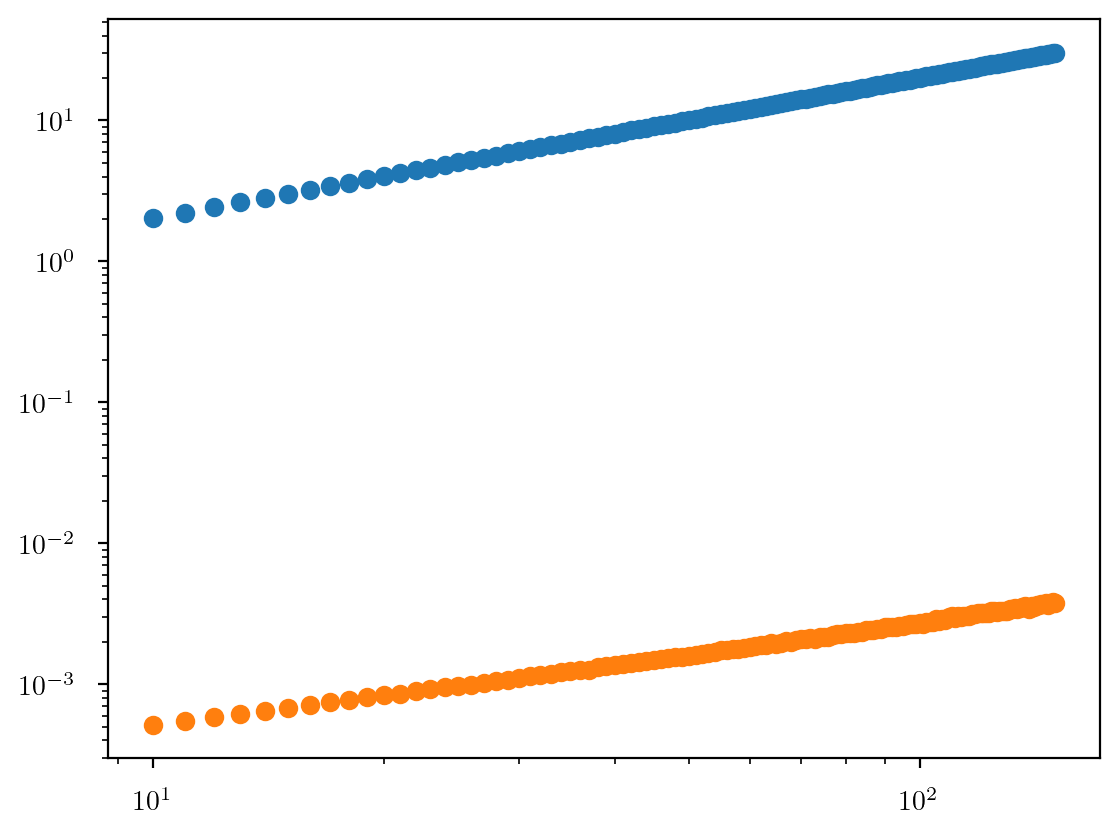

In [9]:
RT_series, VT_series, RT_fit_object, VT_fit_object = find_scale_factors(aggregate_impact_data, alpha=alpha, beta=beta, imbalance_column=imbalance_column)
# Plot scale factors RN and QN
plt.scatter(RT_series['x_values'], RT_series['y_values'])
plt.scatter(VT_series['x_values'], VT_series['y_values'])
plt.loglog()

In [10]:
RT_fit_object.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 20.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.20229272644326335
alpha = 0.9985978555642252

Goodness of fit to data;
D = 0.007633587786259542
bic = -1101.3656815030795
mape = 0.035920439909120305
Adjusted R-squared = 0.9999964547770979




In [11]:
VT_fit_object.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 20.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 7.662979024559248e-05
alpha = 0.7775021573002586

Goodness of fit to data;
D = 0.022900763358778626
bic = -2646.158828290294
mape = 1.4071756354587723
Adjusted R-squared = 0.9978742028900865




### Determine rescaling exponents
In order to determine the rescaling exponents $\chi$ and $\varkappa$, the shape of the scaling form is fitted for each $T$ keeping the same/constant values of $\alpha$ and $\beta$,</b> which are well approximated by the power law.

In [12]:
chi = RT_fit_object.powerlaw.params.alpha
kappa = VT_fit_object.powerlaw.params.alpha
print(chi)
print(kappa)

0.9985978555642252
0.7775021573002586


### Do FSS by method of Least-squares
We can now substitute the emeprical scaling behaviour for $R_T$ and $V_T$ and use the found scaling law to perform the fss.

In [9]:
# Prepare original data for fitting
t_values = aggregate_impact_data['T'].values
imbalance_values = aggregate_impact_data[imbalance_column].values
r_values = aggregate_impact_data['R'].values

# Fit data for all Ts
params = fit_scaling_law(t_values, imbalance_values, r_values, reflect_y=True)

KeyboardInterrupt: 

In [ ]:
chi, kappa, alpha, beta, CONST = params
print(f'chi: {chi}')
print(f'kappa: {kappa}')
print(f'alpha: {alpha}')
print(f'beta: {beta}')

We plot the scaling for different binning_frequencies, where aggregate impact after a trade "appears" to grow linear in volume imbalance with increasing $T$.

In [36]:
binning_frequencies = [10, 20, 50, 100, 150]

In [39]:
from market_impact.util.utils import smooth_outliers, bin_data_into_quantiles

In [40]:
binned_data = []
data = aggregate_impact_data.copy()

for T in binning_frequencies:
    aggregate_impact = data[data["T"] == T][["T", imbalance_column, "R"]]
    smoothed_data = smooth_outliers(aggregate_impact, columns=[imbalance_column, "R"])
    all_binned_data = bin_data_into_quantiles(smoothed_data, x_col=imbalance_column, y_col="R", q=21,duplicates="drop")

    # Concatenate binned data
    binned_data.append(all_binned_data)
    all_binned_data = pd.concat(binned_data, axis=0)

In [43]:
from market_impact.function_form import scaling_function, scaling_law

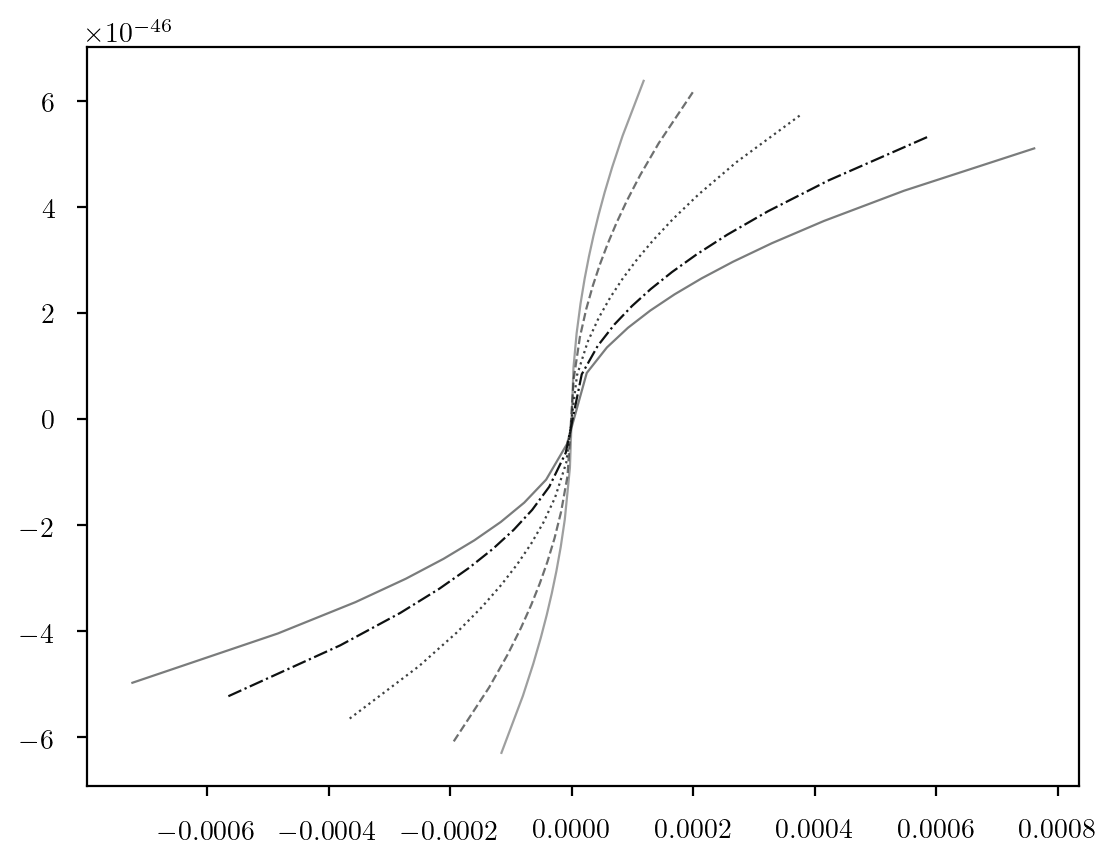

In [47]:
LINE_STYLE = ['-', '--', ':', '-.', 'solid', 'dashed', 'dashdot', 'dotted']
ALPHA = [0.4, 0.6, 0.8, 1, 0.55]
MARKERS = ['P', 'o', 's', '^', 'D']
FACE_COLORS = ['white', 'white', '#0E1111', 'white', 'white']

scaling_func = True
reflect_y = False

for indx, T in enumerate(binning_frequencies):
    data = all_binned_data[all_binned_data["T"] == T][["T", imbalance_column, "R"]]

    # Prepare data for plotting
    t_values = data["T"].values
    r_values = data["R"].values
    imbalance_values = data[imbalance_column].values
    if not reflect_y:
        orderflow_imbalance = pd.DataFrame({"T": t_values, "imbalance": imbalance_values})
    else:
        orderflow_imbalance = pd.DataFrame({"T": t_values, "imbalance": -imbalance_values})
    
    y_hat = scaling_law(orderflow_imbalance, *params)

    # Get color from colormap
    # color = scalar_map.to_rgba(T)

    # Plot data
#     plt.scatter(x=imbalance_values, y=r_values,
#                 s=25,
#                 linewidths=0.5,
#                 label=f"T = {T}",
#                 edgecolor='#1A1919',
#                 facecolor=FACE_COLORS[indx],
#                 alpha=ALPHA[indx % len(LINE_STYLE)],
#                 marker=MARKERS[indx % len(MARKERS)],
#     )

    if scaling_func:
        sns.lineplot(x=imbalance_values, y=y_hat,
                         color='#0E1111',
                         linewidth=0.8,
                         markeredgewidth=0.5,
                         alpha=ALPHA[indx % len(ALPHA)],
                         linestyle=LINE_STYLE[indx % len(LINE_STYLE)])

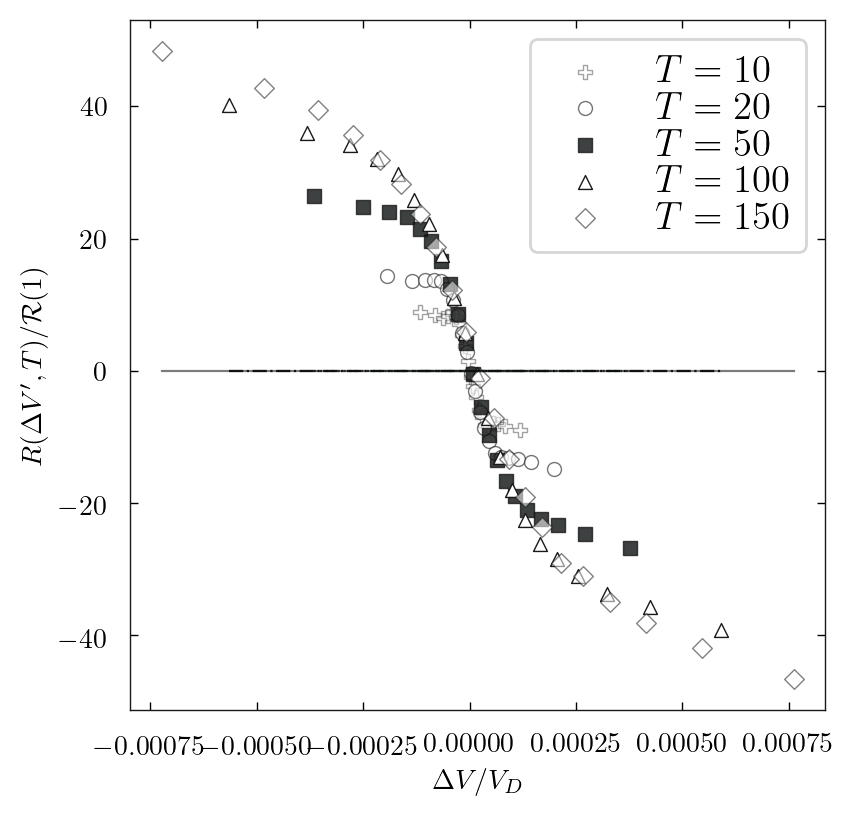

In [33]:
plot_scaling_function(aggregate_impact_data, params=params, 
                      imbalance_column=imbalance_column, 
                      scaling_func=True, reflect_y=True)

### Transform data
To do the fss by method of least-squares, we use optimized critical paramters to rescale the scaling function onto a single master curve by initially fitting the scaling law to all $T$.

In [16]:
# Transform original data using found rescaling exponents chi 𝛘 and kapp ϰ
rescaled_data = transform(aggregate_impact_data, rescaling_params=params, imbalance_column=imbalance_column)

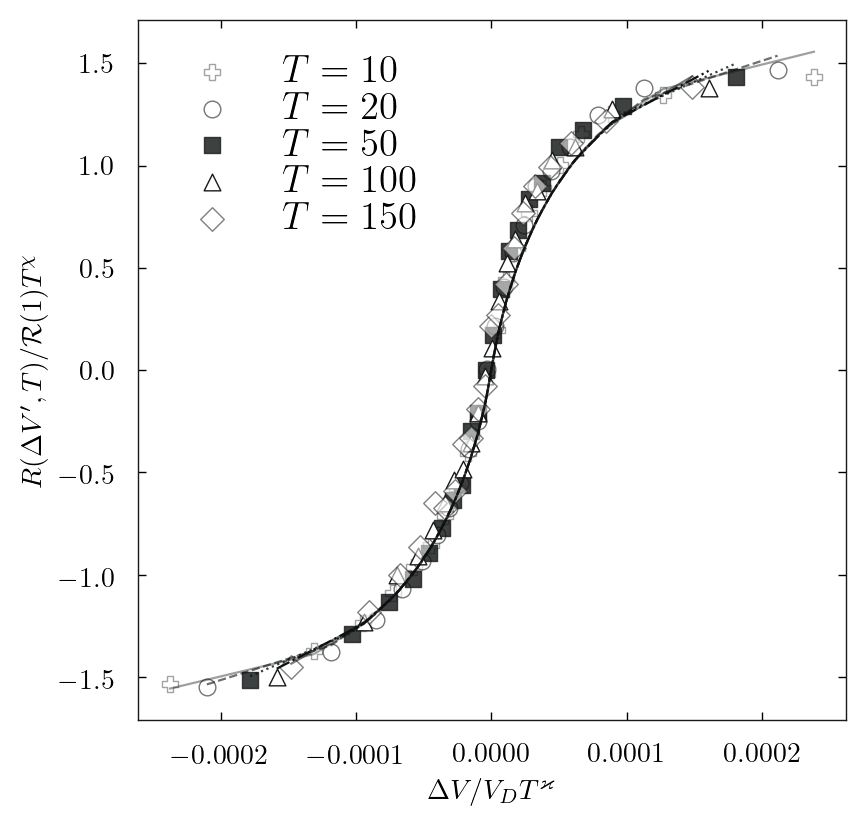

In [34]:
plot_collapsed_scaling_function(rescaled_data, params=params, imbalance_column=imbalance_column, master_curve=True)